# Project 2 - Using Feed-Forward Neural Networks for linear and logistic regression
## **Part d)** - Classification analysis with FFNN
#### Program imports and defaults

In [8]:
from networkClasses import *
from classSupport import *
from methodSupport import *

import autograd.numpy as anp
from autograd import grad,elementwise_grad
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate

import pandas as pd

## Random seed
def_seed = 15
np.random.seed(def_seed); anp.random.seed(def_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (8,3); plt.rcParams["font.size"] = 10

### Wisconsin Breast Cancer Dataset and Neural Network
#### Data preprocessing

In [9]:
anp.random.seed(def_seed)

cancer =  load_breast_cancer() #load_iris()
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

inputs = cancer.data; targets = cancer.target
'''
num = 15
height = anp.random.normal(1.85,0.075,num)
weight = anp.random.normal(90,25,num)
print(height)
print(weight)

dataset = anp.zeros((num,2))
dataset[:,0] = height
dataset[:,1] = weight
print(dataset)
inputs = dataset
targets = dataset[:,1]/dataset[:,0]
print(targets)
#'''

print('Input data shape   :',inputs.shape)
print('Target matrix shape:',targets.shape)
print('Target names       :',cancer.target_names)
print('Target classes     : [    ',targets.min(),'        ',targets.max(),'  ]') #

#print(cancer.feature_names)
## Train-test splitting
test_size = 1/8
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,targets,test_size=test_size,random_state=def_seed)
#inputs_train, inputs_test, targets_train, targets_test = inputs,inputs,targets,targets
## Data scaling
scaler = StandardScaler() #StandardScaler() MinMaxScaler()
scaler.fit(inputs_train)
inputs_train_s = scaler.transform(inputs_train)
inputs_test_s = scaler.transform(inputs_test)
#print(scaler.mean_)
#print(scaler.var_)
#print(inputs_test[:5,:5])
#print(inputs_test_s[:5,:5])

Input data shape   : (569, 30)
Target matrix shape: (569,)
Target names       : ['malignant' 'benign']
Target classes     : [     0          1   ]


#### Covariance matrix for the dataset

In [10]:
corr_matrix = cancerpd.corr().round(1)
'''
EigVals, EigVecs = anp.linalg.eig(corr_matrix)
print(EigVals)
permute = EigVals.argsort()
EigVals = EigVals[permute]
EigVecs = EigVecs[:,permute]
print(EigVals)
print(EigVecs[:,0])
'''
show = False
if show == True:
    fig,ax = plt.subplots(1,1,figsize=(12,8))
    ax = sns.heatmap(corr_matrix,annot=True)
    
    fig, axes = plt.subplots(15,2,figsize=(10,20))
    malignant = cancer.data[cancer.target == 0]
    benign = cancer.data[cancer.target == 1]
    ax = axes.ravel()

    for i in range(30):
        _, bins = np.histogram(cancer.data[:,i], bins =50)
        ax[i].hist(malignant[:,i], bins = bins, alpha = 0.5)
        ax[i].hist(benign[:,i], bins = bins, alpha = 0.5)
        ax[i].set_title(cancer.feature_names[i])
        ax[i].set_yticks(())
    ax[0].set_xlabel("Feature magnitude")
    ax[0].set_ylabel("Frequency")
    ax[0].legend(["Malignant", "Benign"], loc ="best")
    fig.tight_layout()
    plt.show()

#### Network setup

(eta,lmbda) 0.01 1e-07
Prediction accuracy, test data    : 0.9583333333333334
Prediction accuracy, training data: 0.9738430583501007
Loss: 1.3842048152810689
Loss: 1.3842048152810689


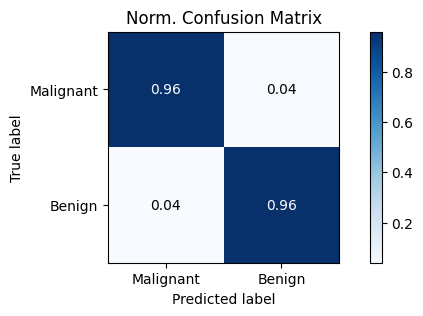

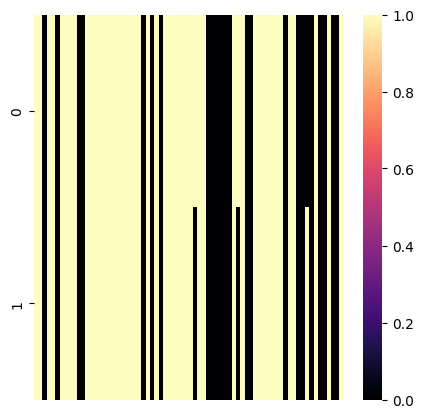

In [14]:
anp.random.seed(def_seed)

n_inputs,n_features = inputs_train_s.shape

layer_output_sizes = [15,10,1]

hidden_func  = sigmoid #sigmoid, ReLU, expReLU, LeakyReLU, identity, tanh
hidden_der = sigmoid_der #elementwise_grad(hidden_func)
#hidden_der = elementwise_grad(hidden_func)

act_funcs = []; act_ders = []
for i in range(len(layer_output_sizes)-1):
    act_funcs.append(hidden_func)
    act_ders.append(hidden_der)
act_funcs.append(sigmoid); 
output_der = sigmoid_der #elementwise_grad(act_funcs[-1]); 
#output_der = elementwise_grad(act_funcs[-1]); 
act_ders.append(output_der)

cost_func = log_loss
cost_der  = log_loss_der #grad(cost_func,0)

network_cl = FFNeuralNework(network_input_size=n_features,layer_output_size=layer_output_sizes,
                            activation_functions=act_funcs,activation_derivatives=act_ders,
                            cost_function=cost_func,cost_derivative=cost_der,random_state=def_seed)

network_cl.create_layers()

## Gradient Descent setup
eta = 1e-2
gamma = 0.000001
lmbda = 1e-7; lp = 2
gamma = 0.0000001
decay = 0.005

batches = 30; epoch = 1000

## Calling the gradient descent (GD)-method
#GDMethod = [PlainGD(eta,lmbda=lmbda,lp=lp),PlainGD(eta,lmbda=lmbda,lp=lp)]
#GDMethod = [MomentumGD(eta,gamma,lmbda=lmbda,lp=lp),MomentumGD(eta,gamma,lmbda=lmbda,lp=lp)]
#GDMethod = [Adagrad(eta,gamma,lmbda,lp=lp),Adagrad(eta,gamma,lmbda,lp=lp)]
GDMethod = [RMSprop(eta,decay=decay),RMSprop(eta,decay=decay)]
#GDMethod = [ADAM(eta),ADAM(eta)]


network_cl.train_network(input=inputs_train_s,target=targets_train,GDMethod=GDMethod,eta=eta,
                                batches=batches,epochs=epoch)

final_prediction = network_cl.predict(inputs_test_s,binary=False)
final_prediction_bin = np.zeros_like(final_prediction)
for k in range(len(final_prediction)):
    if final_prediction[k] >= 0.5:
        final_prediction_bin[k] = 1

final_prediction_train = network_cl.predict(inputs_train_s,binary=False)
final_prediction_train_bin = np.zeros_like(final_prediction_train)
for k in range(len(final_prediction_train)):
    if final_prediction_train[k] >= 0.5:
        final_prediction_train_bin[k] = 1

acc = accuracy_score(targets_test,final_prediction_bin)#network_cl.accuracy(final_prediction,targets=targets_test#print('(eta,gamma)',eta[i],gamma[j])
acc_train = accuracy_score(targets_train,final_prediction_train_bin)
print('(eta,lmbda)',eta,lmbda)
print('Prediction accuracy, test data    :',acc)
print('Prediction accuracy, training data:',acc_train)
print('Loss:',network_cl.cost(inputs_test_s,targets_test))
print('Loss:',log_loss(final_prediction,targets_test))

#print(targets_test - final_prediction_bin)
#print((targets_test - final_prediction_bin)[:5,:5])
ax = confusion_roc_cumul_gains(targets_test,final_prediction[:,0],plots='confusion')
#print('Prediction accuracy:',acc)
fig,cx = plt.subplots(1,1,figsize=(5,5))
#_ = plt.imshow([targets_test,final_prediction_bin[:,0]],aspect='auto')
cx = sns.heatmap([targets_test,final_prediction_bin[:,0]],xticklabels=False,cmap='magma')


#### Repeated training with the same parameters as above

Trained 6 times
(eta,lmbda) 0.01 1e-07
Prediction accuracy: 0.9861111111111112
Final loss: 1.3275977780869628


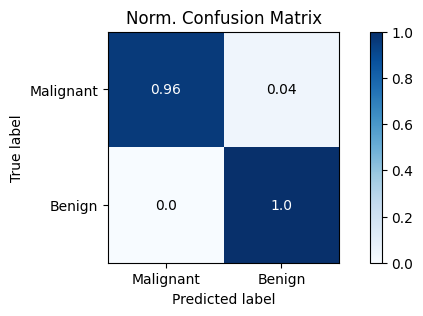

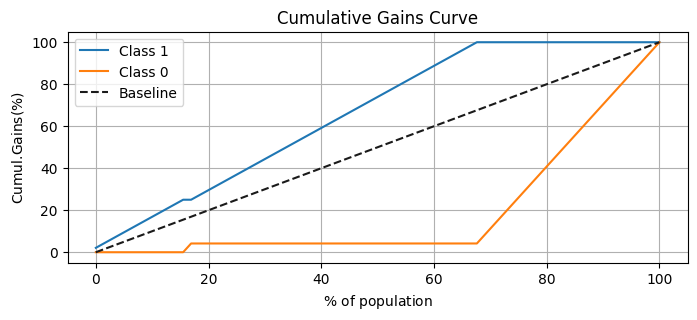

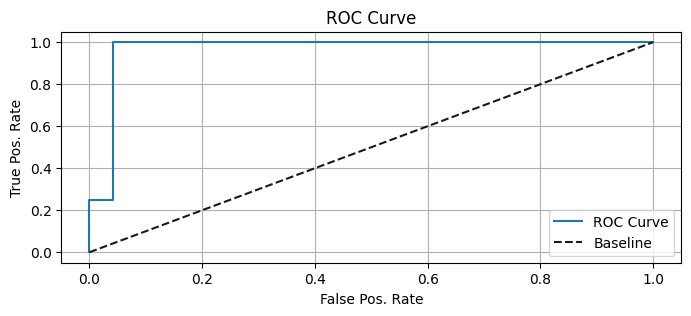

In [85]:
anp.random.seed(def_seed); network_cl.reset()
show = False

layer_output_sizes = layer_output_sizes #[15,5,1]

hidden_func  = sigmoid #sigmoid, ReLU, expReLU, LeakyReLU, identity, tanh
hidden_der = sigmoid_der #elementwise_grad(hidden_func)
#hidden_der = elementwise_grad(hidden_func)

act_funcs = []; act_ders = []
for i in range(len(layer_output_sizes)-1):
    act_funcs.append(hidden_func)
    act_ders.append(hidden_der)
act_funcs.append(sigmoid); 
output_der = sigmoid_der #elementwise_grad(act_funcs[-1]); 
#output_der = elementwise_grad(act_funcs[-1]); 
act_ders.append(output_der)

cost_func = log_loss
cost_der  = log_loss_der #grad(cost_func,0)

network_cl = FFNeuralNework(network_input_size=n_features,layer_output_size=layer_output_sizes,
                            activation_functions=act_funcs,activation_derivatives=act_ders,
                            cost_function=cost_func,cost_derivative=cost_der,random_state=def_seed)

network_cl.create_layers()

## Gradient Descent setup
eta = 1e-2
gamma = 0.000001
lmbda = 1e-7; lp = 2
gamma = 0.0000001
decay = 0.005

batches = 30; epoch = 100

## Calling the gradient descent (GD)-method
#GDMethod = [PlainGD(eta,lmbda=lmbda,lp=lp),PlainGD(eta,lmbda=lmbda,lp=lp)]
#GDMethod = [MomentumGD(eta,gamma,lmbda=lmbda,lp=lp),MomentumGD(eta,gamma,lmbda=lmbda,lp=lp)]
#GDMethod = [Adagrad(eta,gamma,lmbda,lp=lp),Adagrad(eta,gamma,lmbda,lp=lp)]
GDMethod = [RMSprop(eta,decay=decay),RMSprop(eta,decay=decay)]
#GDMethod = [ADAM(eta),ADAM(eta)]

loss = 1; tol = 0.05; iter = 0
acc = 0; acc_train = 0; tol_acc = 0.98
#while loss > tol and iter < 1000:
while acc < tol_acc and iter < 3000:

    network_cl.train_network(input=inputs_train_s,target=targets_train,GDMethod=GDMethod,eta=eta,
                                batches=batches,epochs=epoch)

    final_prediction_train = network_cl.predict(inputs_train_s)
    final_prediction = network_cl.predict(inputs_test_s) 
    
    loss = network_cl.cost(inputs_train_s,targets_train)
    #mse_train = mse_predict(final_prediction_train,targets_train)
    final_prediction_bin_train = np.zeros_like(final_prediction_train)
    final_prediction_bin = np.zeros_like(final_prediction)
    for k in range(len(final_prediction_train)):
        if final_prediction_train[k] >= 0.5:
            final_prediction_bin_train[k] = 1
    for k in range(len(final_prediction)):
        if final_prediction[k] >= 0.5:
            final_prediction_bin[k] = 1
    acc_train = accuracy_score(targets_train,final_prediction_bin_train)
    acc = accuracy_score(targets_test,final_prediction_bin)

    iter += 1
    if iter % 50 == 0:
        print(iter)
        print('Training loss:',loss)
        print('Test acc:',acc)
        print('Training acc:',acc_train)
    

final_prediction = network_cl.predict(inputs_test_s,binary=False)
final_prediction_bin = np.zeros_like(final_prediction)
for k in range(len(final_prediction)):
    if final_prediction[k] >= 0.5:
        final_prediction_bin[k] = 1

acc = accuracy_score(targets_test,final_prediction_bin)#network_cl.accuracy(final_prediction,targets=targets_test#print('(eta,gamma)',eta[i],gamma[j])
print('Trained %i times' %(iter))
print('(eta,lmbda)',eta,lmbda)
print('Prediction accuracy:',acc)
print('Final loss:',network_cl.cost(inputs_test_s,targets_test))

#print(final_prediction)

ax = confusion_roc_cumul_gains(targets_test,final_prediction[:,0])

#### Parameter study, $\eta$, $\lambda$, $\gamma$

In [ ]:
anp.random.seed(def_seed); network_cl.reset()
show = False


## Gradient Descent setup
num_param = 3
eta = anp.logspace(-4,0,num_param)
#gamma = anp.logspace(-10,-4,num_param)
gamme = 0.0#001
lmbda = anp.logspace(-6,-3,num_param)

lp = 2
batches = 10; epoch = 500

LOSS = anp.zeros((len(eta),len(lmbda)))
#LOSS = np.zeros((len(eta),len(gamma)))
ACC = anp.zeros_like(LOSS)
for i in range(len(eta)):
    #for j in range(len(gamma)):
    for j in range(len(lmbda)):

        ## Recreating the layers
        network_cl.create_layers()

        ## Calling the gradient descent (GD)-method
        #GDMethod = [PlainGD(eta[i],lmbda=lmbda[j],lp=lp),PlainGD(eta[i],lmbda=lmbda[j],lp=lp)]
        #GDMethod = [MomentumGD(eta[i],gamma[j],lmbda=lmbda,lp=lp),MomentumGD(eta[i],gamma[j],lmbda=lmbda,lp=lp)]
        GDMethod = [MomentumGD(eta[i],gamma,lmbda=lmbda[j],lp=lp),MomentumGD(eta[i],gamma,lmbda=lmbda[j],lp=lp)]


        network_cl.train_network(input=inputs_train_s,target=targets_train,GDMethod=GDMethod,
                                batches=batches,epochs=epoch)

        final_prediction = network_cl.predict(inputs_test_s,binary=False)
        final_prediction_bin = np.zeros_like(final_prediction)
        
        ## Creating a binary array for the accuracy score
        for k in range(len(final_prediction)):
            if final_prediction[k] >= 0.5:
                final_prediction_bin[k] = 1

        LOSS[i,j] = network_cl.cost(inputs_test_s,targets_test)
        ACC[i,j]  = accuracy_score(targets_test,final_prediction_bin)

        if show == True:
            print(f'{GDMethod[0].__class__.__name__}')
            #print('(eta,gamma)',eta[i],gamma[j])
            print('(eta,lmbda)',eta[i],lmbda[j])
            print('Prediction accuracy:',acc)
            print('Loss:',network_cl.cost(inputs_test_s,targets_test))

        network_cl.reset()

fig,ax = lambda_eta(LOSS,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
fig,bx = lambda_eta(ACC,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )


### Scikit-learn `MLPClassifier`-class

[1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1]
[1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1]
0.9722222222222222
1017
logistic
[array([[ 1.03384048e-01, -5.16013448e-01, -1.76541454e-01,
         2.12667217e-01,  1.44563902e-01,  2.33464758e-01,
         1.79831860e-01, -2.31475758e-01, -1.09854965e-01,
         1.45261970e-01],
       [ 3.21456285e-01, -1.49262266e-01,  3.25337011e-01,
         5.01501908e-01,  3.86238625e-01,  6.11965313e-02,
         4.22220903e-02, -8.98635335e-01, -1.88467621e-01,
        -1.12111417e-01],
       [ 2.25456909e-01, -3.47107169e-01,  2.91736772e-01,
         2.91847389e-01,  3.07715512e-01,  4.97507318e-01,
         4.55553758e-02, -1.47856247e-01, -1.04621013e-01,
         3.26014808e-01],
       [-2.79544126e-01, -2.61596120e-01,  1.96830927e-01,
    

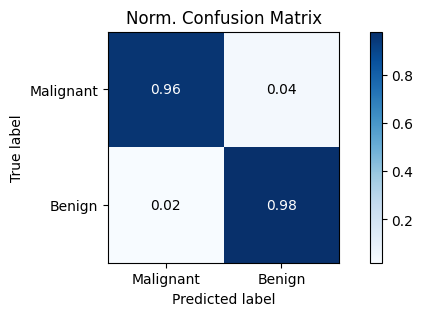

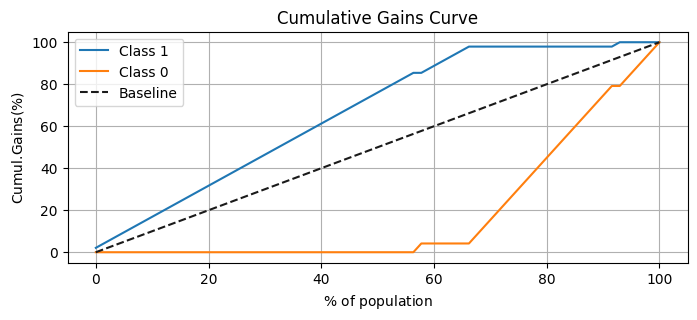

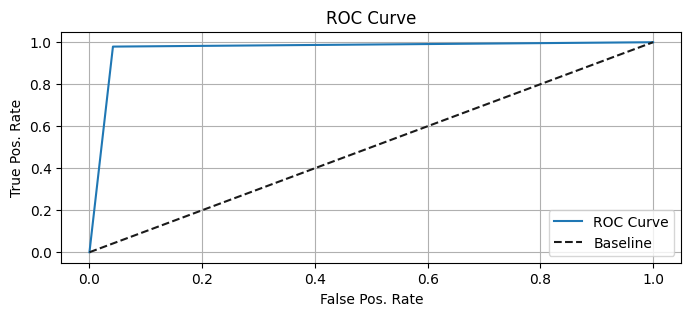

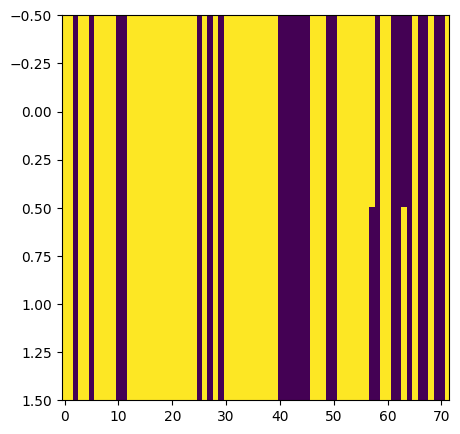

In [27]:
from sklearn.neural_network import MLPClassifier
layer_output_sizes_sci = [10,5,1]; lmbda = 1e-3
network = MLPClassifier(layer_output_sizes_sci,learning_rate_init=0.001,#learning_rate='constant',
                        activation='relu',alpha=lmbda,batch_size=100,
                        solver='adam',random_state=def_seed,max_iter=2000,)

network.fit(inputs_train_s,targets_train)
final_pred = network.predict(inputs_test_s)
print(targets_test)
print(final_pred)
print(network.score(inputs_test_s,targets_test))
print(network.n_iter_)
print(network.out_activation_)
print(network.coefs_)

ax = confusion_roc_cumul_gains(targets_test,final_pred)
plt.figure(figsize=(5,5))
_ = plt.imshow([targets_test,final_pred],aspect='auto')